In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

In [ ]:
caminhoDados = './dados/2025_LoL_esports_match_data_from_OraclesElixir.csv'
dados2025 = pd.read_csv(caminhoDados, low_memory=False)


In [ ]:
df_jogadores_total = dados2025[dados2025['position'] != 'team']

df_times_total = dados2025[dados2025['position'] == 'team']


ligas_desejadas = [
    'LCKC',
    'LCK',
    'LCP',
    'LEC',
    'TCL',
    'LTA S',
    'LTA N',
    'PCS',
    'LTA',
    'VCS',
    'LPLOL'
]



def gerar_df_champions(ligas_desejadas, dados=dados2025, por_posicao=False):
    """
    Gera DataFrame com estatísticas de campeões por liga.
    
    Args:
        ligas_desejadas: Lista de ligas a serem analisadas
        dados: DataFrame com os dados completos
        por_posicao: Se True, retorna dados agrupados por posição. Se False, apenas por campeão.
    
    Returns:
        DataFrame com estatísticas de campeões
    """
    df_jogadores_total = dados[dados['position'] != 'team']
    df_times_total = dados[dados['position'] == 'team']

    df_jogadores = df_jogadores_total[df_jogadores_total['league'].isin(ligas_desejadas)]
    df_times = df_times_total[df_times_total['league'].isin(ligas_desejadas)]

    
    colunas_ban = ['ban1', 'ban2', 'ban3', 'ban4', 'ban5']
    df_bans = pd.melt(
        df_times,
        id_vars=['gameid', 'league'], 
        value_vars=colunas_ban,
        var_name='ban_position',
        value_name='champion_banido'
    )

    champions_banidos = df_bans.groupby('champion_banido')['league'].count().reset_index()
    champions_banidos = champions_banidos.rename(columns={'league': 'bans', 'champion_banido': 'champion'})

    
    total_jogos = df_times['gameid'].nunique()

    if por_posicao:
        
        df_champions_geral = df_jogadores.groupby('champion').agg({
            'result': 'sum',
            'league': 'count'
        }).reset_index()
        
        df_champions_geral = df_champions_geral.rename(columns={'result': 'vitorias', 'league': 'partidas'})
        
        df_champions_geral = pd.merge(
            df_champions_geral, 
            champions_banidos, 
            on='champion', 
            how='left'
        )
        
        df_champions_geral['bans'] = df_champions_geral['bans'].fillna(0).astype(int)
        df_champions_geral['presence rate %'] = (
            (df_champions_geral['bans'] + df_champions_geral['partidas']) / total_jogos
        ).round(2)
        
        
        df_presence_global = df_champions_geral[['champion', 'presence rate %', 'bans']]
        
        
        df_champions = df_jogadores.groupby(['champion', 'position']).agg({
            'result': 'sum',
            'league': 'count'
        }).reset_index()
        
        df_champions = df_champions.rename(columns={'result': 'vitorias', 'league': 'partidas'})
        
        
        df_champions = pd.merge(
            df_champions, 
            df_presence_global, 
            on='champion', 
            how='left'
        )
        
    else:
        
        df_champions = df_jogadores.groupby('champion').agg({
            'result': 'sum',
            'league': 'count'
        }).reset_index()

        df_champions = df_champions.rename(columns={'result': 'vitorias', 'league': 'partidas'})

        df_champions = pd.merge(
            df_champions, 
            champions_banidos, 
            on='champion', 
            how='left'
        )

        df_champions['bans'] = df_champions['bans'].fillna(0).astype(int)
        df_champions['presence rate %'] = (
            (df_champions['bans'] + df_champions['partidas']) / total_jogos
        ).round(2)

    
    df_champions['win rate %'] = np.where(
        df_champions['partidas'] > 0,
        df_champions['vitorias'] / df_champions['partidas'],
        0
    ).round(2)

    
    def calcular_ic(p, n, confianca=0.95):
        if n == 0:
            return 0, 0, 0
        
        z = stats.norm.ppf((1 + confianca) / 2)
        erro_padrao = np.sqrt((p * (1 - p)) / n)
        margem_erro = z * erro_padrao
        
        ic_inf = max(0, p - margem_erro)
        ic_sup = min(1, p + margem_erro)
        amplitude = ic_sup - ic_inf
        
        return ic_inf, ic_sup, amplitude

    
    df_champions['ic_inferior'] = 0.0
    df_champions['ic_superior'] = 0.0
    df_champions['amplitude_ic'] = 0.0

    for idx in df_champions.index:
        p = df_champions.loc[idx, 'win rate %']
        n = df_champions.loc[idx, 'partidas']
        ic_inf, ic_sup, amp = calcular_ic(p, n)
        
        df_champions.loc[idx, 'ic_inferior'] = round(ic_inf, 2)
        df_champions.loc[idx, 'ic_superior'] = round(ic_sup, 2)
        df_champions.loc[idx, 'amplitude_ic'] = round(amp, 2)

    return df_champions

df_lta = gerar_df_champions(['LTA S'],dados2025,True)

df_champions = gerar_df_champions(ligas_desejadas,dados2025,True)

df_champions = df_champions[(df_champions['partidas'] > 25) & (df_champions['amplitude_ic'] <= 0.20)]

df_merged = pd.merge(df_champions, df_lta, on=['champion','position'],how='left', suffixes=('_g','_lta'))

df_merged['percentil_presence_g'] = (df_merged['presence rate %_g'].rank(pct=True) * 100).round(0)

df_merged['percentil_presence_lta'] = (df_merged['presence rate %_lta'].rank(pct=True) * 100).round(0)
df_merged.sort_values(by='win rate %_g', ascending=False)


campeoes_escondidos = df_merged[
    (df_merged['win rate %_g'] >= 0.53) &        
    (df_merged['presence rate %_lta'] < 0.30)         
].sort_values('win rate %_g', ascending=False)


campeoes_escondidos['gap_presence'] = (campeoes_escondidos['presence rate %_g'] - campeoes_escondidos['presence rate %_lta'])
campeoes_escondidos['percentil_gap_presence'] = (campeoes_escondidos['percentil_presence_g'] - campeoes_escondidos['percentil_presence_lta'])



campeoes_escondidos[['champion','position' ,'win rate %_g','win rate %_lta','presence rate %_g', 'presence rate %_lta', 'gap_presence','percentil_gap_presence','percentil_presence_g','percentil_presence_lta','amplitude_ic_g']].sort_values(by='gap_presence', ascending=False)



,champion,position,win rate %_g,win rate %_lta,presence rate %_g,presence rate %_lta,gap_presence,percentil_gap_presence,percentil_presence_g,percentil_presence_lta,amplitude_ic_g
70,Zyra,jng,0.54,0.43,0.18,0.07,0.11,19.0,31.0,12.0,0.20
38,Nidalee,jng,0.55,0.67,0.13,0.03,0.10,18.0,21.0,3.0,0.19
47,Renata Glasc,sup,0.54,0.43,0.16,0.09,0.07,12.0,27.0,15.0,0.15
64,Xayah,bot,0.57,0.56,0.23,0.20,0.03,12.0,46.0,34.0,0.12
68,Yunara,bot,0.59,0.35,0.19,0.17,0.02,6.0,34.0,28.0,0.18
40,Orianna,mid,0.53,0.59,0.26,0.27,-0.01,3.0,54.0,51.0,0.11
33,Maokai,jng,0.56,0.55,0.22,0.25,-0.03,-2.0,44.0,46.0,0.14
5,Annie,mid,0.58,0.48,0.18,0.23,-0.05,-10.0,31.0,41.0,0.14
20,Jarvan IV,jng,0.53,0.47,0.13,0.19,-0.06,-11.0,21.0,32.0,0.14
48,Renekton,top,0.55,0.59,0.21,0.27,-0.06,-12.0,39.0,51.0,0.13


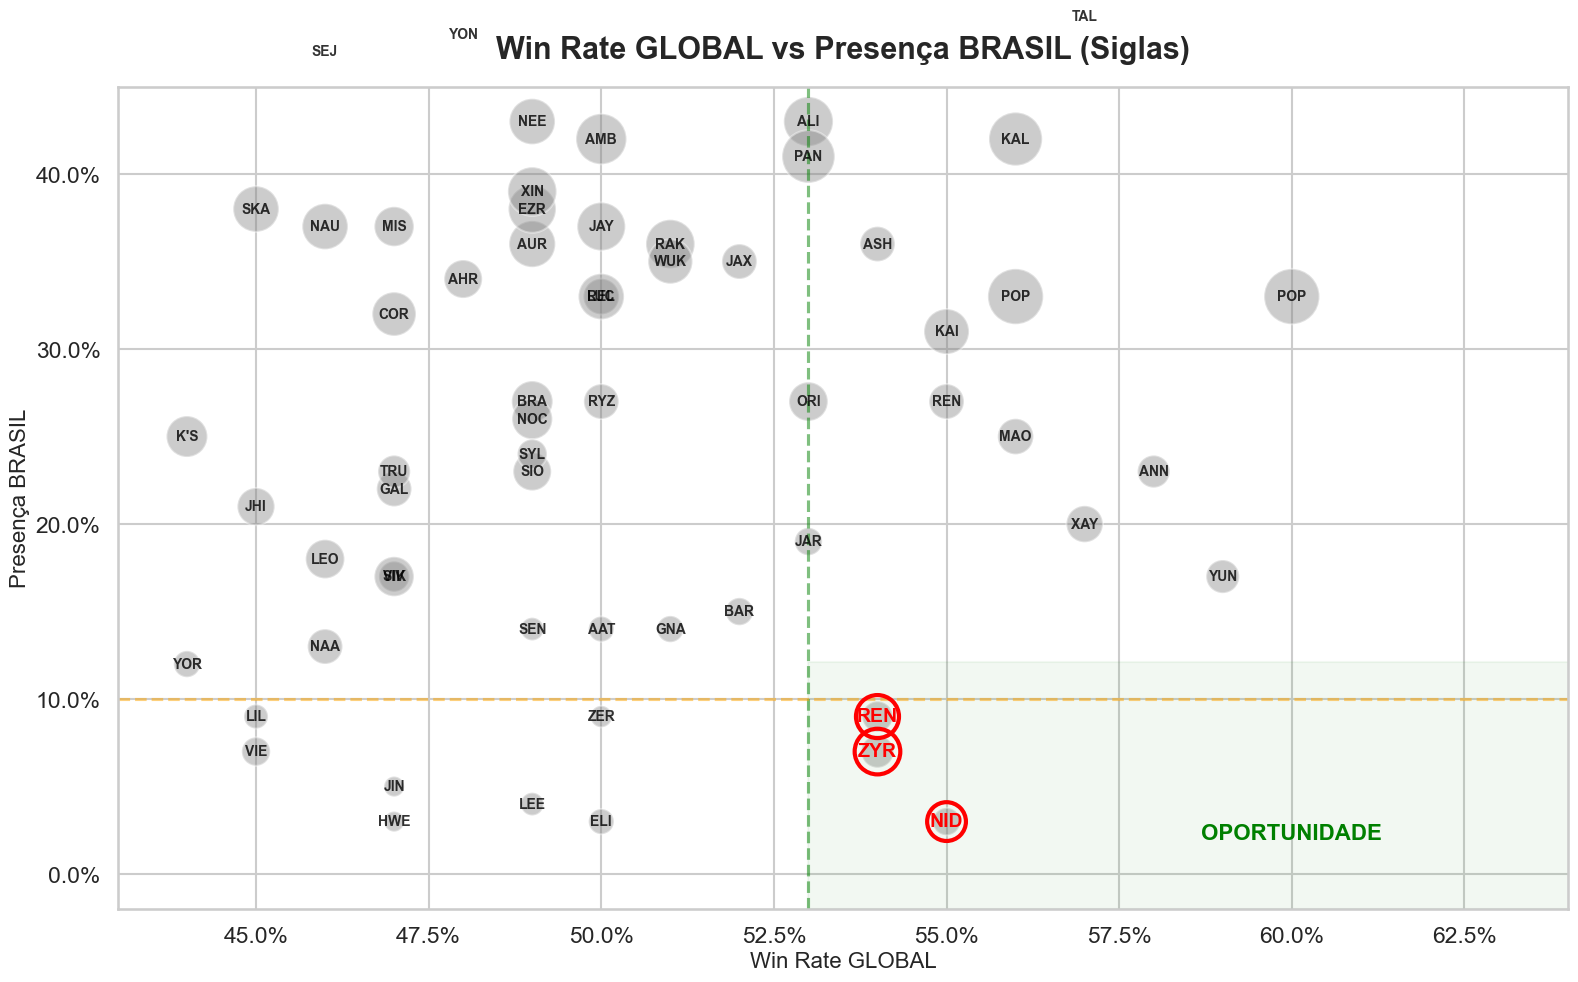

In [ ]:
# Configuração visual "clean"
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 14  # Aumentei a fonte geral

# Criando a figura
plt.figure(figsize=(16, 10))

# Filtrando dados (WR > 43% pra focar no meta)
df_plot = df_merged[(df_merged['win rate %_g'] > 0.43) & (df_merged['presence rate %_lta'] < 0.50)].copy()

# Definindo tamanhos GRANDES
tamanho_bolinha = df_plot['presence rate %_g'] * 3000  # Multiplicador alto pra ficar grande

# 1. SCATTER PLOT GERAL (Fundo)
plt.scatter(
    x=df_plot['win rate %_g'], 
    y=df_plot['presence rate %_lta'], 
    s=tamanho_bolinha,  # Bolinhas grandes
    alpha=0.4, 
    color='gray', 
    edgecolors='white',
    linewidth=1.5
)

# 2. COLOCANDO AS SIGLAS (3 LETRAS) NO MEIO DE TODO MUNDO
destaques = ['Zyra', 'Nidalee', 'Renata Glasc']

for i, row in df_plot.iterrows():
    # Sigla (3 letras)
    sigla = row['champion'][:3].upper()
    
    # Se for destaque
    if row['champion'] in destaques:
        # Pinta a bolinha de vermelho (borda forte)
        plt.scatter(
            row['win rate %_g'], 
            row['presence rate %_lta'], 
            s=row['presence rate %_g'] * 6000, # Mesmo tamanho grande
            facecolors='none', 
            edgecolors='red', 
            linewidth=3,
            zorder=5 # Fica na frente
        )
        # Sigla em VERMELHO e NEGRITO
        plt.text(
            row['win rate %_g'], 
            row['presence rate %_lta'], 
            sigla, 
            ha='center', 
            va='center', 
            fontsize=14, 
            color='red', 
            fontweight='bold',
            zorder=6
        )
    else:
        # Sigla normal em preto/cinza
        plt.text(
            row['win rate %_g'], 
            row['presence rate %_lta'], 
            sigla, 
            ha='center', 
            va='center', 
            fontsize=10, 
            color='black', 
            alpha=0.8,
            fontweight='bold'
        )


plt.axvspan(0.53, 0.65, ymin=0, ymax=0.30, color='green', alpha=0.05)
plt.text(0.60, 0.02, 'OPORTUNIDADE', color='green', fontweight='bold', ha='center', fontsize=16)


plt.axvline(x=0.53, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=0.10, color='orange', linestyle='--', alpha=0.5)


plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title('Win Rate GLOBAL vs Presença BRASIL (Siglas)', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Win Rate GLOBAL', fontsize=16)
plt.ylabel('Presença BRASIL', fontsize=16)

plt.xlim(0.43, 0.64) 
plt.ylim(-0.02, 0.45) 

plt.tight_layout()
plt.show()